# Topic Modelling and Text Classification

<b>Name :</b> Rofin Andonissamy <br>

<b>Description :</b><br>

1. Create topic modelling for a dataset containing real and fake news articles

2. Train a 1D Convolutional Neural Network to classify between real and fake news articles

3. Train a Recurrent Neural Network to classify between real and fake news articles


<b>Deep Learning Framework used:</b> PyTorch<br> 


<b>Note:</b> Weights of the embedding layers are copied from the pretrained model: Glove

In [1]:
#---- Import libraries
#---------------------

#--- For NLP preprocessing
#------------------------ 
import spacy
from spacy.lang.en import English
import time

#-----For Text preprocessing
#---------------------------
import torchtext
import torchtext.data as data
from torchtext.data import Field
from torchtext.data import TabularDataset
import torch.nn.functional as F
import numpy as np
np.random.seed(0)

#----Pytorch framework for modelling neural network
#--------------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(0)
import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
import pandas as pd

#----General libraries for datastructures
from collections import Counter
np.random.seed(10)
import matplotlib.pyplot as plt
#----Text Preprocessing
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from gensim import corpora, models as g_models
from nltk.stem.porter import *
import nltk
nltk.download('wordnet')
from gensim.models.coherencemodel import CoherenceModel


from sklearn.preprocessing import LabelEncoder as le

import seaborn as sn

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Read the input file

In [2]:
#------ Read the training data 
inp_df = pd.read_csv('train.csv')
inp_df.head()

,id,published,title,text,type
0,164889,5/22/2017,Justice Department Narrows Scope Of ’Sanctuary...,Attorney General Jeff Sessions is narrowing th...,Real
1,161890,2/10/2017,First Watch: Aldous Harding’s Elegant Video Fo...,It’s basically three chords banged out on a pi...,Real
2,e7d74d7a8321d6367585210b8aa4d29e16519dbf,2016-11-24T18:20:29.095+02:00,Our Grandmothers Know Best – Traditional Remed...,Our Grandmothers Know Best – Traditional Remed...,fake
3,156366,11/13/2016,Paul Ryan lists Trump-era priorities as he ins...,The wall that Donald Trump has promised to bui...,Real
4,0396c4ce127a5bfe9f545a16118dcad6b4283386,2016-10-29T17:42:18.350+03:00,Supreme Court will hear case on bathroom rules...,The Supreme Court said Friday it will hear a c...,fake


# Data Preprocessing

In [3]:
#----Create a training dataset
#-----------------------------
train_df= pd.DataFrame()

#---- Concatenate the text fields together for modelling
#-------------------------------------------------------
train_df['News'] =  inp_df['title']+':'+inp_df['text']
train_df['Type'] = le().fit_transform(inp_df['type'])

#----Capture the label encodeing details for later reference
#-----------------------------------------------------------
label_encode_df = pd.DataFrame()
encode = le().fit(inp_df['type'])
label_encode_df['Class'] = encode.classes_
label_encode_df['Encoding'] = label_encode_df.index

#---Display the details
#----------------------
print("-"*110)
print("Encoding Details")
print("-"*110)
print(label_encode_df)
print("*"*110)

train_df.head()


--------------------------------------------------------------------------------------------------------------
Encoding Details
--------------------------------------------------------------------------------------------------------------
  Class  Encoding
0  Real         0
1  fake         1
**************************************************************************************************************


,News,Type
0,Justice Department Narrows Scope Of ’Sanctuary...,0
1,First Watch: Aldous Harding’s Elegant Video Fo...,0
2,Our Grandmothers Know Best – Traditional Remed...,1
3,Paul Ryan lists Trump-era priorities as he ins...,0
4,Supreme Court will hear case on bathroom rules...,1


In [0]:
#----Function to lemmatize (remove inflational word endings)
#-----------------------------------------------------------
def lemmatize(inp_text):
    Lemmatizer=WordNetLemmatizer()
    return Lemmatizer.lemmatize(Lemmatizer.lemmatize(Lemmatizer.lemmatize(Lemmatizer.lemmatize(inp_text,pos='v'),pos='a'),pos='r'),pos='n')

#----Function to determine the root word
#---------------------------------------
def stemming(inp_text):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(inp_text)

#----Tokenize and apply pre-processing defined above
#---------------------------------------------------
def preprocess_text(inp_txt):
    proc_txt = []
    for token in gensim.utils.simple_preprocess(str(inp_txt)):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(str(inp_txt)) > 3:
            proc_txt.append(stemming(lemmatize(token)))
    return proc_txt

In [5]:
#---Apply preprocessing to the text columns
preprocesd_docs = train_df['News'].map(preprocess_text)
#---Display to check whether preprocessing is working as desired
preprocesd_docs[:10]

0    [justic, depart, narrow, scope, sanctuari, cit...
1    [watch, aldous, hard, eleg, video, haunt, hori...
2    [grandmoth, know, best, tradit, remedi, asthma...
3    [paul, ryan, list, trump, era, prioriti, insis...
4    [suprem, court, hear, case, bathroom, rule, tr...
5    [modern, histori, rig, elect, licens, dmca, un...
6    [ask, peopl, know, obamacar, know, answer, aff...
7    [feed, say, june, hike, possibl, uk, employ, h...
8    [alex, honnold, scale, el, capitan, rope, clim...
9    [wild, conflict, inform, fbi, actual, renew, c...
Name: News, dtype: object

In [0]:
#----- Seggregate preprocessed versions of all, fake and real documents
#-----------------------------------------------------------------------
all_docs_preprocsd = preprocesd_docs
fake_docs_preprocsd = preprocesd_docs.loc[train_df['Type']==1]
real_docs_preprocsd = preprocesd_docs.loc[train_df['Type']==0]

# Build Vocabulary

In [7]:
#---create vocabulary dictionary (word to id mapping)
#----------------------------------------------------
all_docs_dict = gensim.corpora.Dictionary(all_docs_preprocsd)

#--Filter out the least significant words (Appearing in less than 20 docs,appearing in more than 50% of corpus,)
#---------------------------------------------------------------------------------------------------------------
all_docs_dict.filter_extremes(no_below=15, no_above=0.5, keep_n=None)

#----Print first 5 entries in the ditionary
#-------------------------------------------
count = 0
print("-"*100)
print("Vocabulary List")
print("-"*100)
for k, v in all_docs_dict.iteritems():
    print(k, v)
    count += 1
    if count > 5:
        break

----------------------------------------------------------------------------------------------------
Vocabulary List
----------------------------------------------------------------------------------------------------
0 administ
1 administr
2 ag
3 appli
4 arriv
5 attorney


In [0]:
#---get bag of words corpus for each document in the dictionary (for all,real and fake documents) 
#------------------------------------------------------------------------------------------------
all_docs_bowcorpus= [all_docs_dict.doc2bow(doc) for doc in all_docs_preprocsd]
real_docs_bowcorpus= [all_docs_dict.doc2bow(doc) for doc in real_docs_preprocsd]
fake_docs_bowcorpus= [all_docs_dict.doc2bow(doc) for doc in fake_docs_preprocsd]

# ---get term frequency 
# ---------------------
# Corpus does hold document frequency but not term frequency. Hence manually compute it
def get_term_freq(docs_bowcorpus):
    vocabulary_tf={}
    for i in docs_bowcorpus:
        for word,count in dict(i).items():
            if word in vocabulary_tf:
                vocabulary_tf[word] += count
            else:
                vocabulary_tf[word] = count
    return vocabulary_tf

#----Get TFIDF corpus for LDA modelling
#--------------------------------------
def get_tfidf_corpus(docs_bowcorpus):
    #----Calculate TFIDF
    tfidf = g_models.TfidfModel(docs_bowcorpus)
    return tfidf[docs_bowcorpus]

# Frequently occurring words

<i><u>Note:</i></u> Since stemmer has been used, some words may seem to have slightly incorrect spelling 

In [9]:
def freq_words():
    all_docs_df = Counter(get_term_freq(all_docs_bowcorpus))
    real_docs_df = Counter(get_term_freq(real_docs_bowcorpus))
    fake_docs_df = Counter(get_term_freq(fake_docs_bowcorpus))

    print("20 Most Frequent words in entire data")
    print("-"*110)
    for k,v in all_docs_df.most_common(20):
        print('Word:\"{}\" \t occurs:{} times'.format(all_docs_dict[k],v))
    print("-"*110)

    print("20 Most Frequent words in real news")
    print("-"*110)
    for k,v in real_docs_df.most_common(20):
        print('Word:\"{}\" \t occurs:{} times'.format(all_docs_dict[k],v))
    print("-"*110)

    print("20 Most Frequent words in fake news")
    print("-"*110)
    for k,v in fake_docs_df.most_common(20):
        print('Word:\"{}\" \t occurs:{} times'.format(all_docs_dict[k],v))
    print("-"*110)

freq_words()

20 Most Frequent words in entire data
--------------------------------------------------------------------------------------------------------------
Word:"trump" 	 occurs:33626 times
Word:"state" 	 occurs:20821 times
Word:"clinton" 	 occurs:18805 times
Word:"know" 	 occurs:16439 times
Word:"go" 	 occurs:15854 times
Word:"presid" 	 occurs:15801 times
Word:"think" 	 occurs:14709 times
Word:"report" 	 occurs:14464 times
Word:"work" 	 occurs:14366 times
Word:"american" 	 occurs:13127 times
Word:"day" 	 occurs:12624 times
Word:"elect" 	 occurs:12621 times
Word:"tell" 	 occurs:12592 times
Word:"world" 	 occurs:12467 times
Word:"way" 	 occurs:12287 times
Word:"want" 	 occurs:11756 times
Word:"right" 	 occurs:11572 times
Word:"countri" 	 occurs:11334 times
Word:"hillari" 	 occurs:11032 times
Word:"nation" 	 occurs:10918 times
--------------------------------------------------------------------------------------------------------------
20 Most Frequent words in real news
-----------------------

In [0]:
#-----Generate TDIDF Scores
#--------------------------
tfidf_corpus_4_real = get_tfidf_corpus(real_docs_bowcorpus)
tfidf_corpus_4_fake = get_tfidf_corpus(fake_docs_bowcorpus)

# Build LDA Model

In [0]:
#----Create multiple instances of LDA model with different topic numbers and respective coherence scores
def LDAModel(start,end,stepsize,corpus,doct_dict):
    coh_values = []
    models = []
    num_topic = []
    for num_topics in range(start, end, stepsize):
        LDA_Model = g_models.LdaMulticore(corpus, num_topics=num_topics, id2word=doct_dict, passes=2, workers=2)
        models.append(LDA_Model)
        coh_model = CoherenceModel(model=LDA_Model, texts=preprocesd_docs, dictionary=doct_dict, coherence='c_v')
        coh_values.append(coh_model.get_coherence())
    return models,coh_values

## LDA for Real news

In [0]:
#------Get LDA and respective coherent score for Real news corpus
lda_models_real,coh_score_real = LDAModel(2,14,2,tfidf_corpus_4_real,all_docs_dict)

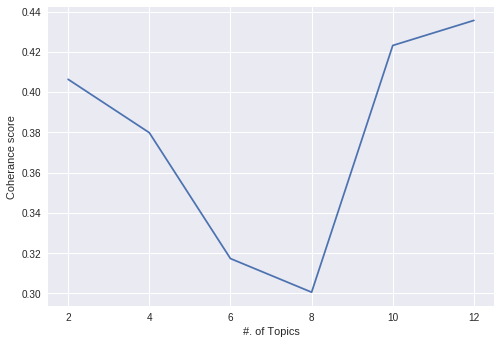

In [14]:
#---- Plot the coherence scores for different number of topics to identify the ideal number of topics
plt.plot(range(2,14,2), coh_score_real)
plt.xlabel("#. of Topics")
plt.ylabel("Coherance score")
plt.show()


#### From the above plot, we can infer that the coherence score is high for the model with  10 topics. Hence the ideal number of topics for real news corpus is 10 

In [15]:
print("-"*110)
print("Topics determined for real news:")
print("-"*110)
for idx,topic in lda_models_real[4].print_topics(-1):
        print('\n Topic:{} \n Word: {}'.format(idx,topic))


--------------------------------------------------------------------------------------------------------------
Topics determined for real news:
--------------------------------------------------------------------------------------------------------------

 Topic:0 
 Word: 0.003*"appl" + 0.002*"trump" + 0.002*"uber" + 0.001*"compani" + 0.001*"china" + 0.001*"fbi" + 0.001*"whale" + 0.001*"iphon" + 0.001*"facebook" + 0.001*"eu"

 Topic:1 
 Word: 0.004*"trump" + 0.003*"clinton" + 0.003*"sander" + 0.003*"cruz" + 0.003*"voter" + 0.002*"rubio" + 0.002*"vote" + 0.002*"candid" + 0.002*"poll" + 0.002*"republican"

 Topic:2 
 Word: 0.007*"trump" + 0.003*"presid" + 0.003*"republican" + 0.003*"senat" + 0.002*"court" + 0.002*"hous" + 0.002*"democrat" + 0.002*"health" + 0.002*"state" + 0.002*"law"

 Topic:3 
 Word: 0.002*"trump" + 0.001*"polic" + 0.001*"pipelin" + 0.001*"space" + 0.001*"record" + 0.001*"jazz" + 0.001*"oil" + 0.001*"protest" + 0.001*"facebook" + 0.001*"music"

 Topic:4 
 Word: 0.002*"

## LDA Model for Fake news

In [0]:
#------Get LDA for fake news
lda_models_fake,coh_score_fake = LDAModel(2,14,2,tfidf_corpus_4_fake,all_docs_dict)

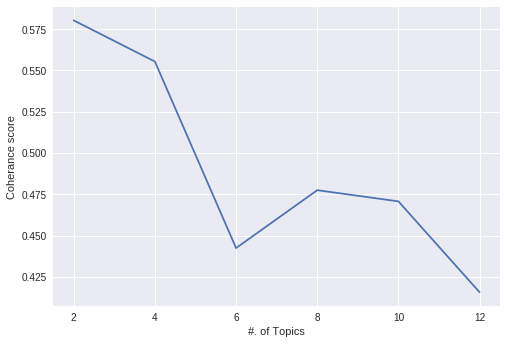

In [17]:
plt.plot(range(2,14,2), coh_score_fake)
plt.xlabel("#. of Topics")
plt.ylabel("Coherance score")
plt.show()

#### From the above plot, we can infer that the coherence score is high for the model with  2 topics. Hence the ideal number of topics for real news corpus is 2 

In [18]:
print("-"*110)
print("Topics determined for fake news:")
print("-"*110)
for idx,topic in lda_models_fake[0].print_topics(-1):
        print('\n Topic:{} \n Word: {}'.format(idx,topic))


--------------------------------------------------------------------------------------------------------------
Topics determined for fake news:
--------------------------------------------------------------------------------------------------------------

 Topic:0 
 Word: 0.003*"trump" + 0.003*"clinton" + 0.002*"vote" + 0.002*"hillari" + 0.002*"russia" + 0.002*"syria" + 0.002*"email" + 0.001*"war" + 0.001*"presid" + 0.001*"elect"

 Topic:1 
 Word: 0.003*"trump" + 0.003*"clinton" + 0.002*"hillari" + 0.002*"elect" + 0.002*"email" + 0.002*"fbi" + 0.001*"world" + 0.001*"vote" + 0.001*"american" + 0.001*"obama"


# Text Classification using CNN

In [0]:
#----Instantiate Spacy English module for tokenization
#-----------------------------------------------------
spacy_en = English()

#----Tokenize function 
#--------------------
def tokenize(doc): # create a tokenizer function
    return [token.text for token in spacy_en.tokenizer(doc)]

In [20]:
from sklearn import preprocessing

#-----Define label encoder 
#-------------------------
def label_encoder(x):
    if(x.lower().strip()=='real'):
        x=0
    else:
        x=1
    return x
  

#------ Define text pre-processing pipeline for input text (news) and label:
#--------------------------------------------------------------------------

NEWS  = Field(sequential=True,tokenize=tokenize, lower=True)
LABEL = Field(sequential= False,use_vocab=False,lower=True,preprocessing= label_encoder) 

#---Apply the pre-processing pipeline defined above to the required columns of input file
#----------------------------------------------------------------------------------------
train_fields = [("id", None), ("published", None), ("title", None), 
                ("text", NEWS),("type", LABEL)]

#path='./',
#----Since train and test files has the same structure and requires same preprocessing
#----Create relevent datasets using the same field mappings

train_dataset = TabularDataset( path= 'train.csv', format='CSV', 
                               skip_header=True, fields=train_fields)


test_dataset  = TabularDataset( path= 'test.csv', format='CSV', 
                               skip_header=True, fields=train_fields)

#----Check the datasets to verify if the text are being read accordingly
#----------------------------------------------------------------------
print("Training dataset\n","-"*100)
print('The keys in dataset:\n',train_dataset[0].__dict__.keys(),
      '\n\ninput vector:\n',train_dataset[0].text[:10])

print("Test dataset\n","-"*100)
print('The keys in dataset:\n',test_dataset[0].__dict__.keys(),
      '\n\ninput vector:\n',test_dataset[0].text[:10])



Training dataset
 ----------------------------------------------------------------------------------------------------
The keys in dataset:
 dict_keys(['text', 'type']) 

input vector:
 ['attorney', 'general', 'jeff', 'sessions', 'is', 'narrowing', 'the', 'scope', 'of', 'an']
Test dataset
 ----------------------------------------------------------------------------------------------------
The keys in dataset:
 dict_keys(['text', 'type']) 

input vector:
 ['politics', 'british', 'prime', 'minister', 'theresa', 'may', 'waits', 'for', 'the', 'arrival']


In [21]:
#-----build vocabulary
#---------------------
NEWS.build_vocab(train_dataset,max_size=30000,vectors="glove.6B.100d")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#-----Define iterator to load training data
#------------------------------------------
train_iterator= data.BucketIterator(train_dataset, batch_size = 32,  
                                    sort_key=lambda x: len(x.text), 
                                    sort_within_batch=False,repeat = False,
                                    device=device)

#-----Define iterator to load test data
#------------------------------------------
test_iterator= data.BucketIterator(test_dataset, batch_size = 32,  
                                   sort_key=lambda x: len(x.text), 
                                   sort_within_batch=False,repeat = False,
                                   device=device)

.vector_cache/glove.6B.zip: 862MB [11:44, 1.22MB/s]                           
100%|█████████▉| 398978/400000 [00:20<00:00, 19882.81it/s]

In [0]:
class SimpleCNN(nn.Module):
    def __init__(self, inp_dim, embed_chl, n_filters, 
                 filter_size, output_dim, dropout, pad_idx):
        super().__init__()
        #----Embedding layer(takes numericalized seq. of words as input and produces 100 channels 
        #----(based on the glove vector) of o/p)
        self.embedding = nn.Embedding(inp_dim, embed_chl, padding_idx=pad_idx)
        
        #---- Convolution layers to learn 3-gram,4-gram and 5-gram features of the text
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = embed_chl, out_channels = n_filters, 
                                              kernel_size = fs) for fs in filter_size])
        
        #----- Fully connected layer
        self.fc = nn.Linear(len(filter_size) * n_filters, output_dim)
        #---- Dropout layer
        self.dropout = nn.Dropout(dropout)
    
    #---- Forward Propogaion
    def forward(self, text):
        
        
        #----Transpose the incoming matrix so that the dimension will be batch size * text length
        text = text.permute(1, 0)
        embedded = self.embedding(text) #adds embed_chl 3. of channels (batch size * text length * embed_chl)
                
        #----Rearrange the data (batch size*embed_chl*text_lengh)        
        embedded = embedded.permute(0, 2, 1)
        
        #----Apply convolution operation (3,4,5 filter sizes) with relu non-linearity as activation function
        #----Each convolution will reduce the dimentsion by ((text_len-filter_size)/stride) -1
        conved = [F.relu(conv(embedded)) for conv in self.convs] 
            
        #----Apply maxpool1d
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]  #(batch size, n_filters)
        
        #---concatenate the dimensions and apply dropout
        cat = self.dropout(torch.cat(pooled, dim=1))
        #---return the fully connected layer
        return self.fc(cat)


#----- Populate the dimension
#----------------------------

#----Length of the vocabulary (Input size)
inp_dim = len(NEWS.vocab)        
#---- #. of Embedding channels should be equal to the number of filters (100)
embed_chl = n_filters = 100
#---- Filter sizes (to read the features of 3-gram,4-gram and 5-gram)
filter_size = [3,4,5]
#---- #. of output classes (1 - 0 or 1)
output_dim = 1
#---- Dropout to reduce exploding gradient 
dropout = 0.5
#----- Padding index
pad_idx = NEWS.vocab.stoi[NEWS.pad_token]

#-----Instantiate the model
model = SimpleCNN(inp_dim, 
                  embed_chl, 
                  n_filters, 
                  filter_size, 
                  output_dim, 
                  dropout, 
                  pad_idx)

In [23]:
model

SimpleCNN(
  (embedding): Embedding(30002, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5)
)

In [24]:
#-----check the number of trainable parameter in the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,120,801 trainable parameters


In [25]:
#-----Copy Pretrained embedding weights to the model
#----------------------------------------------------
model.embedding.weight.data.copy_(NEWS.vocab.vectors)


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.0371, -0.2098, -0.0383,  ...,  0.2884,  0.0683, -0.8658],
        [-0.0132,  0.3681,  0.4478,  ..., -0.9901, -0.1159,  0.1895],
        [-0.3322, -0.6721, -0.0505,  ..., -0.4044, -0.1407,  0.0277]])

In [0]:
# # #----Check if GPU is available for use, else use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#---Loss function
criterion = nn.BCEWithLogitsLoss()

# Initialize the optimizer function- ADAM optimization
optimizer = optim.Adam(model.parameters(), lr=0.001)#optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #optim.SGD(model.parameters(), lr=1e-2,)

model = model.to(device)
criterion = criterion.to(device)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [0]:
#-----Function to calcualte the accuracy
def appraise_accuracy(preds, y):
    #---round predictions to the closest integer by applying sigmoid function
    rounded_preds = torch.round(torch.sigmoid(preds))
    #---Calculate the accuracy
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum()/len(correct)
    return acc

In [0]:
#------Define a function to train the model
def train(model, iterator, optimizer, criterion):
    #----reset epoch variables
    epoch_loss = 0
    epoch_acc = 0
    
    #---set the model to train mode
    model.train()
    
    #-----Iterate through each mini batch
    for batch in iterator:
        #---Initialize the weights
        optimizer.zero_grad()
        
        #Make prediction
        predictions = model(batch.text).squeeze(1)
        
        #---calculate loss
        loss = criterion(predictions, batch.type.float())
        
        #---appraise accuracy
        acc = appraise_accuracy(predictions, batch.type.float())
        
        #---backwrd propogation
        loss.backward()
        optimizer.step()
        #---accumulate the loss and accuracy        
        epoch_loss += loss.item()
        epoch_acc += acc.item() 
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
#-----Function to test the model 
def evaluate(model, iterator, criterion):
    #---Initialize epoch variables
    epoch_loss = 0
    epoch_acc = 0
    y_pred = None
    y_truth = None


    #---put the model into evaluation mode so that gradiants wont be adjusted
    model.eval()
    
    with torch.no_grad():
    #---iterate through the mini batches
        for batch in iterator:
            #---make prediction
            predictions = model(batch.text).squeeze(1)
            #---appraise loss and accuracy
            loss = criterion(predictions, batch.type.float())
            acc = appraise_accuracy(predictions, batch.type.float())
            #---accumulate the loss and accurac
            epoch_loss += loss.item()
            epoch_acc += acc.item()

            #---accumulate the labels and prediction
            y_pred_tmp = (torch.round(torch.sigmoid(predictions))).cpu().numpy()
            if y_pred is None:
                y_pred = y_pred_tmp
                y_truth = batch.type.float().cpu().numpy()
            else:
                y_pred = np.append(y_pred,y_pred_tmp)  
                y_truth =np.append(y_truth,batch.type.float().cpu().numpy())
                  
    return epoch_loss/len(iterator), epoch_acc/len(iterator),y_pred,y_truth

In [0]:
import time
#---function to evaluate the time interval between each epoch
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Train the CNN

In [35]:
#-----------Train the convolutional network 
N_EPOCHS = 6

for epoch in range(N_EPOCHS):

    #---record the start time
    start_time = time.time()
    #train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    #---record the end time
    end_time = time.time()

       
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print("-"*115)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Accuracy: {train_acc*100:.2f}%')
    print("-"*115,'\n')
    
    

-------------------------------------------------------------------------------------------------------------------
Epoch: 01 | Epoch Time: 1m 2s
	Train Loss: 0.002 | Train Accuracy: 99.98%
------------------------------------------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------------------------------------------
Epoch: 02 | Epoch Time: 1m 2s
	Train Loss: 0.001 | Train Accuracy: 99.98%
------------------------------------------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------------------------------------------
Epoch: 03 | Epoch Time: 1m 2s
	Train Loss: 0.000 | Train Accuracy: 100.00%
------------------------------------------------------------------------------------------------------------------- 

---------------------------------------------------------------------------

# Evaluate the model 

In [36]:
test_loss, test_acc,y_cap,y = evaluate(model, test_iterator, criterion)

print(f'\tTest Loss: {test_loss:.3f} | Test Accuracy: {test_acc*100:.2f}%')


	Test Loss: 0.011 | Test Accuracy: 99.65%


In [37]:
#---- Label description for confusion matrix
labl_descr = {0:'Genuine',1:'Fake'}

#---Confusion matrix
#-------------------
cm = confusion_matrix(y,y_cap)
cm_df = pd.DataFrame(cm)
cm_df = cm_df.rename(labl_descr, axis='index')
cm_df = cm_df.rename(labl_descr, axis='columns')
print("Confusion Matrix:\n")
cm_df

Confusion Matrix:



,Genuine,Fake
Genuine,1966,1
Fake,12,1761


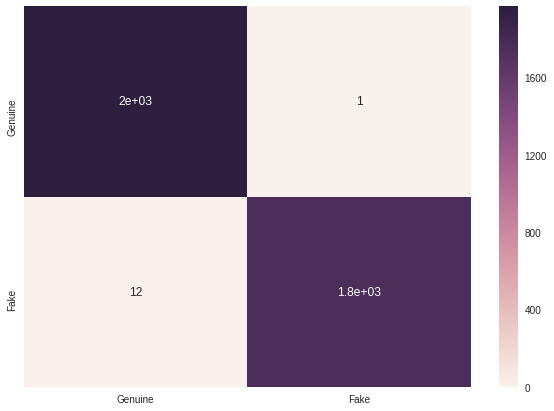

In [39]:
plt.figure(figsize = (10,7))
sn.heatmap(cm_df, annot=True)

In [38]:
print ('Accuracy Score :\n','-'*100,'\n',accuracy_score(y, y_cap)) 


Accuracy Score :
 ---------------------------------------------------------------------------------------------------- 
 0.996524064171123


In [40]:
print ('\nClassification Report :\n','-'*100,'\n',classification_report(y, y_cap) )


Classification Report :
 ---------------------------------------------------------------------------------------------------- 
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      1967
         1.0       1.00      0.99      1.00      1773

   micro avg       1.00      1.00      1.00      3740
   macro avg       1.00      1.00      1.00      3740
weighted avg       1.00      1.00      1.00      3740



# Text Classification using RNN

In [0]:
class SimpleRNN(nn.Module):
    def __init__(self, inp_dim, embed_chl, hidden_dim, output_dim, dropout, pad_idx):
        super().__init__()
        #----Embedding layer(takes numericalized seq. of words as input and produces 100 channels 
        #----(based on the glove vector) of o/p)
        
        self.embedding = nn.Embedding(inp_dim, embed_chl, padding_idx=pad_idx)
        
        #---- LSTM layers to analyse the pattern
        self.lstm = nn.LSTM(embed_chl,hidden_dim,num_layers=2,bidirectional=True,dropout=dropout)
        
        #----- Fully connected layer
        self.fc = nn.Linear(hidden_dim *2 , output_dim)
        
        #---- Dropout
        self.dropout = nn.Dropout(dropout)
       
    
    #---- Forward Propogaion
    def forward(self, text):
        #---- text length * batch size
        embedded = self.embedding(text) 
        
        #----Apply dropout for regularization
        embedded = self.dropout(embedded)
               
        #----LSTM
        out,(hidden,cell)   = self.lstm(embedded)
        
        #---Since it is birectional lstm concate forward feed and backward pass
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        
        return self.fc(hidden.squeeze(0))



#----- Populate the dimension
#----------------------------

#----Length of the vocabulary (Input size)
inp_dim = len(NEWS.vocab)        
#---- #. of Embedding channels should be equal to the number of filters (100)
embed_chl = 100
#---- hidden dimension
hidden_dim = 256

#---- #. of output classes (1 - 0 or 1)
output_dim = 1
#---- Dropout to reduce exploding gradient 
dropout = 0.5
#----- Padding index
pad_idx = NEWS.vocab.stoi[NEWS.pad_token]

#-----Instantiate the model
model_rnn = SimpleRNN(inp_dim, 
                  embed_chl, 
                  hidden_dim,
                  output_dim, 
                  dropout, 
                  pad_idx)

In [42]:
model_rnn

SimpleRNN(
  (embedding): Embedding(30002, 100, padding_idx=1)
  (lstm): LSTM(100, 256, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5)
)

In [43]:
#-----Copy Pretrained embedding weights to the model
#----------------------------------------------------
model_rnn.embedding.weight.data.copy_(NEWS.vocab.vectors)


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.0371, -0.2098, -0.0383,  ...,  0.2884,  0.0683, -0.8658],
        [-0.0132,  0.3681,  0.4478,  ..., -0.9901, -0.1159,  0.1895],
        [-0.3322, -0.6721, -0.0505,  ..., -0.4044, -0.1407,  0.0277]])

In [0]:
#------Define a function to train the model
def train1(model, iterator, optimizer, criterion):
    #----reset epoch variables
    epoch_loss = 0
    epoch_acc = 0
    
    #---set the model to train mode
    model.train()
    model = model.cuda()
    
    #-----Iterate through each mini batch
    for batch in iterator:
        #---Initialize the weights
        optimizer.zero_grad()
        
        #Make prediction
        predictions = model(batch.text).squeeze(1)
        
        #---calculate loss
        loss = criterion(predictions, batch.type.float())
        
        #---appraise accuracy
        acc = appraise_accuracy(predictions, batch.type.float())
        
        #---backwrd propogation
        loss.backward()
        optimizer.step()
        #---accumulate the loss and accuracy        
        epoch_loss += loss.item()
        epoch_acc += acc.item() 
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
N_EPOCHS = 1

for epoch in range(N_EPOCHS):

    #---record the start time
    start_time = time.time()
    #train the model
    train_loss, train_acc = train1(model_rnn, train_iterator, optimizer, criterion)
    #---record the end time
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    
    print("-"*115)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print("-"*115,'\n')

In [0]:
test_loss_rnn, test_acc_rnn,y_cap_rnn,y_rnn = evaluate(model_rnn, test_iterator, criterion)

print(f'\tTest Loss: {test_loss_rnn:.3f} | Test Accuracy: {test_acc_rnn*100:.2f}%')


	Test Loss: 0.693 | Test Accuracy: 52.64%


In [0]:
#---- Label description for confusion matrix
labl_descr = {0:'Genuine',1:'Fake'}

#---Confusion matrix
#-------------------
cm_rnn = confusion_matrix(y_rnn,y_cap_rnn)
cm_rnn_df = pd.DataFrame(cm_rnn)
cm_rnn_df = cm_rnn_df.rename(labl_descr, axis='index')
cm_rnn_df = cm_rnn_df.rename(labl_descr, axis='columns')
print("Confusion Matrix:\n")
cm_rnn_df

Confusion Matrix:



,Genuine,Fake
Genuine,1960,7
Fake,1764,9


In [0]:
print ('\nClassification Report :\n','-'*100,'\n',classification_report(y_rnn, y_cap_rnn) )


# Summary
##### Naïve Bayes vs Deep Neural Network

Naive bayes are conditional classifiers which assumes independance assumptions between the features. Therefore, they rely on the occurances of features to perform classification. This means in our case, naive bayes merely checks the occurances of words and the order of the words does not really influence the classification. Therefore, it ignores the crucial aspect such as semantics and context of the sentences in text corpus. On contrast, neural network considers the sequence of the words in a given stream of data and learns the pattern of text to determine the context and semantics, thereby it is more effective and suitable for a NLP and classification of text stream.


##### List of major topics identified from real news articles:

Terrorism,Syria War, public policies in US under Trump administration,Zika Virus outbreak,entertainment, education,election,social network

Below is the significant topic identified from the fake articles in the given dataset 
Allegations against Trump and Hillary Clinton during US presidential election

##### Data Preprocessing
Stream of text should be tokenized ie. the sentences should be broken into words. Now the words can be lemmatized to remove the inflated endings and stemming could be leveraged to obtain the root words.After this conversion the stopwords can be determined and eliminated as the stopwards will not influence classification. Similarly, term frequence and inverse document frequencey can be assesed to ignore insignificant word from corpus.Finally, there sequences of work can be converted into a vector of numericals which can be fed into the model.
In case of CNN, lemmatization and stemming is not carried out so as to enable to the network to learn Natural language processing

